In [ ]:
# Install the necessary libraries
!pip install transformers datasets evaluate tensorflow

import tensorflow as tf
import numpy as np
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import evaluate

# --- 1. Load data using TensorFlow/Keras ---

# Keras provides the dataset already split and integer-encoded
(x_train_int, y_train), (x_test_int, y_test) = tf.keras.datasets.imdb.load_data()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
# --- 2. Decode the integer sequences back to text ---

# Get the word-to-index mapping
word_index = tf.keras.datasets.imdb.get_word_index()

# Create a reverse index (integer-to-word)
# The first 3 indices are reserved for special tokens
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>" # Unknown word

# Create functions to decode the reviews
def decode_review(encoded_review):
    """Converts a sequence of integers back to a string."""
    return " ".join([reverse_word_index.get(i, "?") for i in encoded_review])

# Decode all reviews
decoded_x_train = [decode_review(review) for review in x_train_int]
decoded_x_test = [decode_review(review) for review in x_test_int]

# --- 3. Convert the data into a Hugging Face Dataset object ---

# Create dictionaries compatible with the Dataset object
train_data = {"text": decoded_x_train, "label": y_train}
test_data = {"text": decoded_x_test, "label": y_test}

# Create Dataset objects
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
 #4. Tokenize the text data
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

# 5. Prepare for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="my_awesome_model_tf",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1056855169.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 6. Train and evaluate
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.230600,0.207784,0.923720
2,0.154500,0.233253,0.927840


{'eval_loss': 0.20778395235538483,
 'eval_accuracy': 0.92372,
 'eval_runtime': 338.4017,
 'eval_samples_per_second': 73.877,
 'eval_steps_per_second': 4.619,
 'epoch': 2.0}

In [ ]:
import numpy as np
from sklearn.metrics import classification_report


# 2. Get predictions for the test dataset
results = trainer.predict(tokenized_test_dataset)

# The results object contains predictions (logits) and true labels
predictions = results.predictions
true_labels = results.label_ids

# 3. Convert logits to class predictions
preds = np.argmax(predictions, axis=1)

# 4. Generate a detailed classification report
# Specify the target names for better readability
target_names = ['Negative', 'Positive']
report = classification_report(true_labels, preds, target_names=target_names)

print("\n--- Classification Report ---")
print(report)


--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.92      0.93      0.92     12500
    Positive       0.93      0.92      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



In [ ]:
from transformers import pipeline
import os

# --- Load Model and Predict ---

# Define the path to your training output directory
output_dir = "my_awesome_model_tf"

# Find the latest checkpoint directory (or specify it manually)
# This is a helper to automatically find the last saved checkpoint
try:
    latest_checkpoint = max(
        [os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("checkpoint-")],
        key=os.path.getmtime
    )
    print(f"Loading model from: {latest_checkpoint}")
except ValueError:
    print(f"Error: No checkpoint found in '{output_dir}'. Please ensure the path is correct.")
    latest_checkpoint = None

if latest_checkpoint:
    # Create a sentiment-analysis pipeline with your fine-tuned model
    classifier = pipeline("sentiment-analysis", model=latest_checkpoint)

    # New reviews to classify
    new_reviews = [
        "This movie was an absolute masterpiece, I was captivated from start to finish!",
        "I was so bored I almost fell asleep. The plot was completely unoriginal."
    ]

    # Get predictions
    results = classifier(new_reviews)

    # Print results in a readable format
    for review, result in zip(new_reviews, results):
        print(f"\nReview: '{review}'")
        print(f"Prediction: {result['label']} (Score: {result['score']:.4f})")

Device set to use cuda:0


Loading model from: my_awesome_model_tf/checkpoint-3126

Review: 'This movie was an absolute masterpiece, I was captivated from start to finish!'
Prediction: POSITIVE (Score: 0.9963)

Review: 'I was so bored I almost fell asleep. The plot was completely unoriginal.'
Prediction: NEGATIVE (Score: 0.9958)


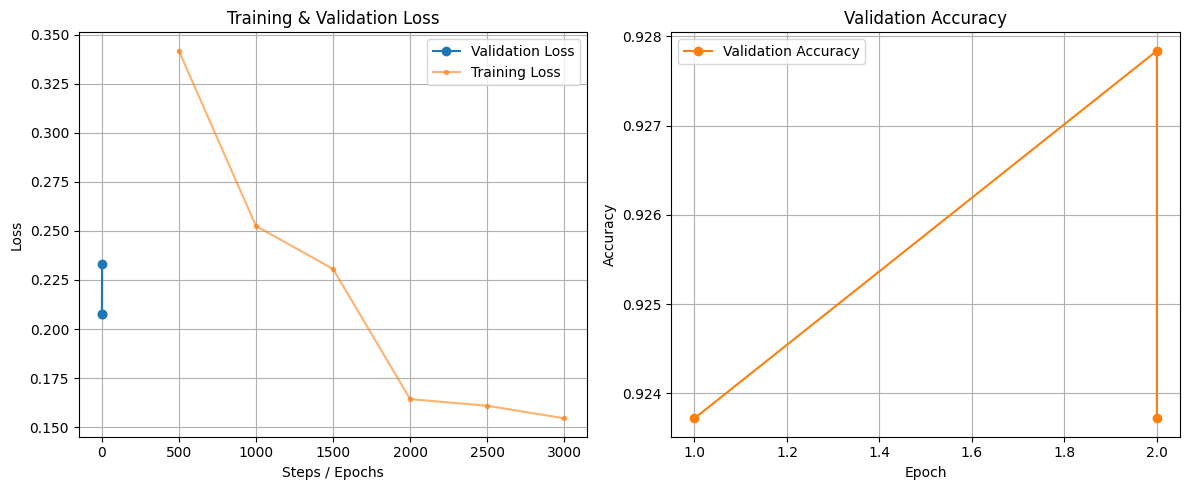

In [ ]:
import matplotlib.pyplot as plt

# --- This code runs AFTER trainer.train() is complete ---

# Extract the training history from the trainer
log_history = trainer.state.log_history

# Separate training loss, validation loss, and validation accuracy
train_loss = [x['loss'] for x in log_history if 'loss' in x]
val_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
val_accuracy = [x['eval_accuracy'] for x in log_history if 'eval_accuracy' in x]
epochs = [x['epoch'] for x in log_history if 'eval_loss' in x]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Training and Validation Loss ---
ax1.plot(epochs, val_loss, 'o-', label='Validation Loss')
# The training loss is logged at each step, not each epoch,
# so we create a separate x-axis for it.
train_steps = [x['step'] for x in log_history if 'loss' in x]
ax1.plot(train_steps, train_loss, '.-', label='Training Loss', alpha=0.6)

ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Steps / Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)


# --- Plot 2: Validation Accuracy ---
ax2.plot(epochs, val_accuracy, 'o-', label='Validation Accuracy', color='C1')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()